In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os, sys, camb
from camb import model, initialpower
from astropy import units as u, constants as c
from scipy.interpolate import interp1d

import utils as ut
import props as p
import lines as l
from importlib import reload
reload(ut)
reload(p)
reload(l)

TIM = p.TIM
GAL = p.AstroDeep
#GAL = p.Euclid
CII = l.CII

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h

sigCoef = np.sqrt(8*np.log(2))
lilh = True

dlnk = 0.6

# TODO(shubh): figure out what this value is and how it comes in, and units

#colors = ['black', 'purple', 'blue', 'gold', 'red', 'black']
colors = ['purple', 'blue', 'gold', 'red']
linestyles = ['-','--',':','-.']

In [2]:
# define our bins
bins = [
    ut.zBin(TIM.SW.zmin, TIM.SW.zcen),
    ut.zBin(TIM.SW.zcen, TIM.SW.zmax),
    ut.zBin(TIM.LW.zmin, TIM.LW.zcen),
    ut.zBin(TIM.LW.zcen, TIM.LW.zmax),
]

bin_zs = [b.center.value for b in bins]

bands = ['SW', 'SW', 'LW', 'LW'] 

print("TIM bins:")
for b in bins:
    print(f"z in [{b.front:.3f}, {b.back:.3f}]")

TIM bins:
z in [0.521, 0.766]
z in [0.766, 1.010]
z in [1.010, 1.336]
z in [1.336, 1.663]


In [3]:
LSbins = [ut.Survey(b, TIM[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]
# LIM survey objects for each bin

for lsb in LSbins:
    print(lsb.cell_noise(TIM.time))

703036143029.9122 Jy2 Mpc3 / s2
1331424515709.3281 Jy2 Mpc3 / s2
635017875208.6002 Jy2 Mpc3 / s2
972729789399.3834 Jy2 Mpc3 / s2


In [4]:
#Sanity check on the kscale of the bin LoS
for lsb in LSbins:
    print(np.around(lsb.LoS, 2), 'or k = ', np.around(2*np.pi / lsb.LoS, 4))

508.99 Mpc or k =  0.0123 1 / Mpc
439.17 Mpc or k =  0.0143 1 / Mpc
497.76 Mpc or k =  0.0126 1 / Mpc
416.27 Mpc or k =  0.0151 1 / Mpc


In [5]:
k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

print(len(k_xyz_modes))
[print(kxyzs.shape) for kxyzs in k_xyz_modes]

4
(3, 20, 102, 39)
(3, 20, 102, 29)
(3, 15, 77, 39)
(3, 15, 77, 30)


[None, None, None, None]

In [6]:
# these arrays are similarly structured:
# arr[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

# magnitudes of the k vectors
k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 

# minimum k magnitude in each survey bin
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]

# unit kx, ky, kz vectors for each mode in each survey bin
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# num of k bins given our dlnk
num_kbins = [round(ut.num_log_steps(k_min, np.max(km), dlnk)) + 1 \
    for k_min, km in zip(k_mins, k_mags)]

num_kbins

C:\Users\juzz\AppData\Local\Temp\ipykernel_32656\478757844.py:13: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]


[16, 15, 15, 14]

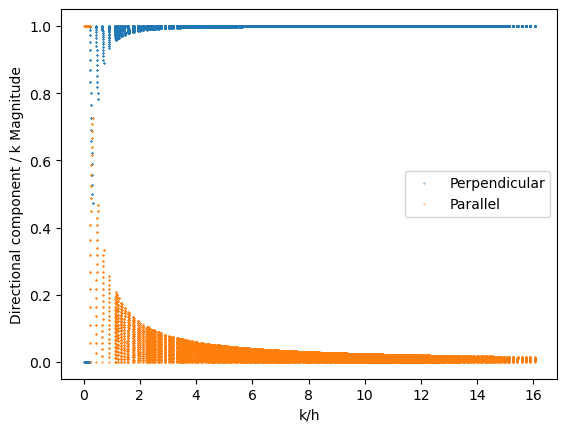

In [7]:
# making a plot for bin1
plt.figure()
plt.plot(k_mags[0].flatten(), (k_props[0][0] ** 2 + k_props[0][1] ** 2).flatten(), marker='.', linestyle='None', markersize=.6, label = 'Perpendicular')
#plt.plot(k1Mag.flatten(), ky1Props.flatten(), marker='.', linestyle='None')
plt.plot(k_mags[0].flatten(), k_props[0][2].flatten(), marker='.', linestyle='None', markersize=.6, label = 'Parallel')
plt.xlabel('k/h')
plt.ylabel('Directional component / k Magnitude')
plt.legend()

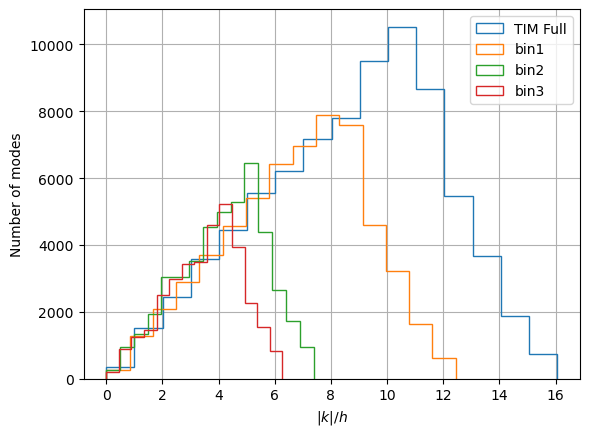

In [8]:
plt.figure()
for i in range(len(k_mags)):
    if i == 0 or i == 5:
        plt.hist(k_mags[i].flatten(), bins=num_kbins[i], alpha = 1, label = 'TIM Full', histtype='step')
    else:
        plt.hist(k_mags[i].flatten(), bins=num_kbins[i], alpha = 1, label = f'bin{i}', histtype='step')

plt.xlabel(r'$|k|/h$')
plt.ylabel('Number of modes')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [9]:
# resolution elements Sigma_perpendicular (transverse) and sigma_par (LoS)
s_perps = [b.transScale(TIM[band].FWHM).value / sigCoef for b, band in zip(bins, bands)]
s_pars = [ut.dnu2dr(TIM[band].dnu, b.center).value / sigCoef for b, band in zip(bins, bands)]

In [10]:
s_perps

[0.11755244692217426,
 0.1516503189988713,
 0.24571221408768276,
 0.28908943552124405]

In [11]:
# outer product of the these three gaussians
windows = [np.einsum('i,j,k->ijk', 
                np.exp(-kxyzs[0][:, 0, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[1][0, :, 0]**2 * s_perp**2 / 2), 
                np.exp(-kxyzs[2][0, 0, :]**2 * s_par**2 / 2)) 
                for kxyzs, s_perp, s_par in zip(k_xyz_modes, s_perps, s_pars)]

In [12]:
windows[0].shape

(20, 102, 39)

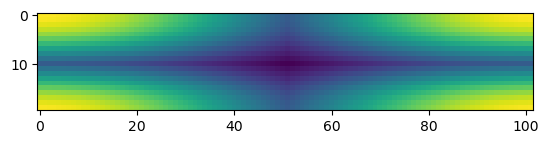

In [13]:
plt.figure()
plt.imshow(windows[0][:, :, 0])
plt.show()
plt.close()

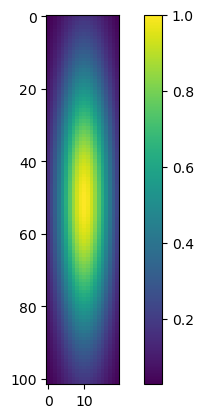

In [14]:
plt.figure()
plt.imshow(np.fft.fftshift(windows[0][:, :, 0]).T ** 2)
plt.colorbar()
plt.show()
plt.close()

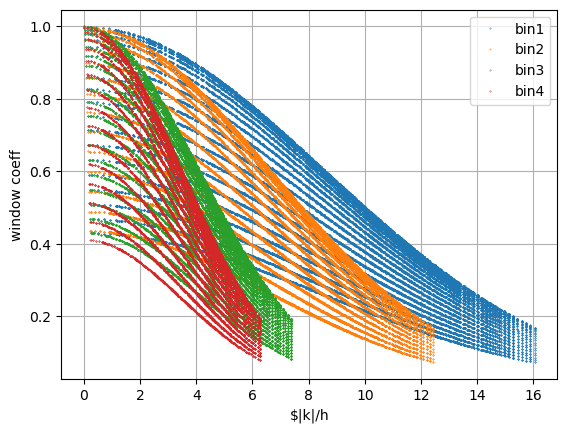

In [15]:
plt.figure()
for i in range(len(k_mags)):
    plt.plot(k_mags[i].flatten(), windows[i].flatten(), marker='.', \
    linestyle='None', label = 'bin'+str(i+1), markersize=.6)

plt.xlabel(r'$|k|/h')
plt.ylabel('window coeff')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [16]:
# CAMB time, have to remove last redshift because there is a duplication
# and CAMB doesn't like that

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, As=2e-9, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.set_matter_power(redshifts=bin_zs[:-1], kmax=np.max(k_maxs) * 3, nonlinear=True) 
# TODO: why not nonlinear?
# TODO: why not much higher kmax?

results = camb.get_results(pars)

Note: redshifts have been re-sorted (earliest first)


In [17]:
binned_results = [results.get_matter_power_spectrum(minkh=kmin, maxkh=np.max(km), npoints=nkb) \
    for kmin, km, nkb in zip(k_mins, k_mags, num_kbins)]

z_idxs = [np.argmin(np.abs(zs - binz)) for (_, zs, _), binz in zip(binned_results, bin_zs)]
print(z_idxs)

Pms = [(ks, Pm[z_idx]) for (ks, _, Pm), z_idx in zip(binned_results, z_idxs)]

[0, 1, 2, 2]


In [18]:
kbin_edges = [np.append([0], np.sqrt(ks * np.append(ks[1:], [np.max(km)])))
            for km, (ks, _) in zip(k_mags, Pms)]
# get bin edges by selecting the midway between each CAMB k prediction
# use geometric mean because bins are log-spaced

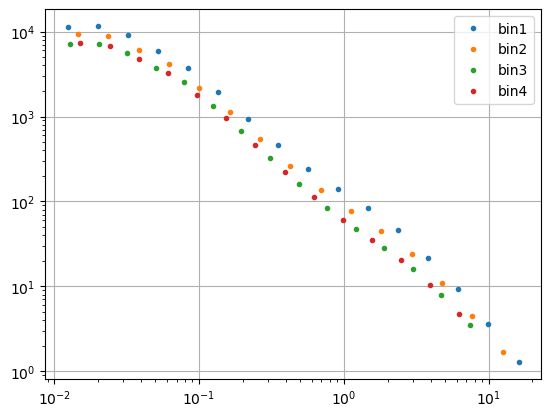

In [19]:
plt.figure()
for i in range(len(Pms)):
    plt.plot(Pms[i][0], Pms[i][1], label = 'bin'+str(i+1), linestyle='none', marker='.')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [20]:
3.38994999e-03 / 5.44490142e-03, 9.34911274e-02 / 1.50164449e-01 # log scale from CAMB

(0.622591618931459, 0.6225916188724536)

In [21]:
window_avgs = [np.array([np.mean(win[np.logical_and(km < kb[i+1], km >= kb[i])]) 
                for i in range(len(kb)-1)]) 
        for win, km, kb in zip(windows, k_mags, kbin_edges)]

C:\Users\juzz\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\juzz\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


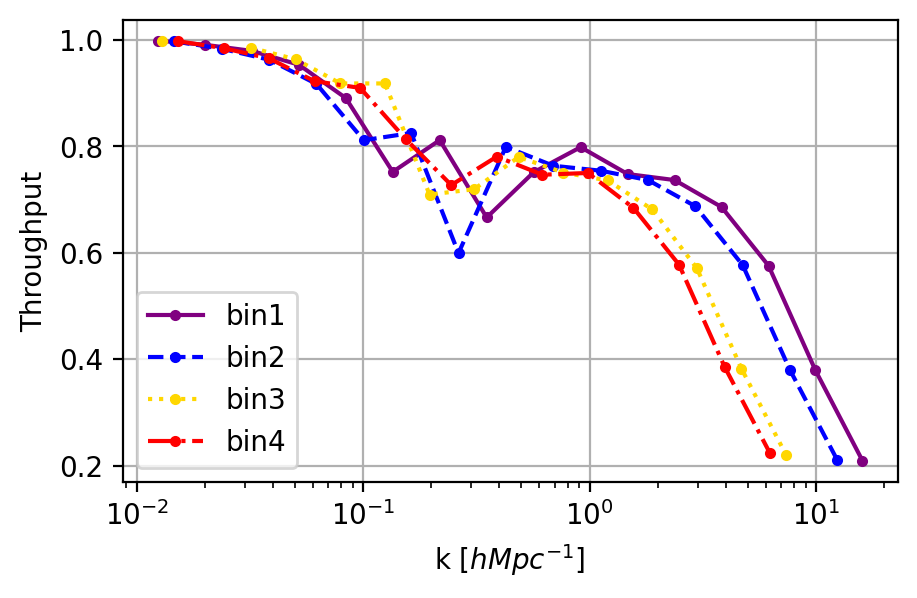

In [22]:
plt.figure(dpi = 200, figsize = (5,3))
for i in range(len(Pms)):
    plt.plot(Pms[i][0], window_avgs[i], label = 'bin'+str(i+1), marker='.', 
             color = colors[i], linestyle = linestyles[i])

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel('Throughput')
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()
plt.close()

In [23]:
sfrds = [ut.MD_sfrd(z) for z in bin_zs]
Iciis = np.array([CII.Inu(sfrd, z).value for sfrd, z in zip(sfrds, bin_zs)])

In [24]:
fs = 0.897 #Proportion of Galaxy sample galaxies that are line emitters
#TODO- Juzz - Recall where we got this number.
Igal, bCII, bstar = 1, 1, 3

x_shots = fs * Iciis / GAL.n_gals # cross shot for TIMxGal
PxGs = [(bstar * Icii * Igal * Pm) + x_shot 
            for Icii, x_shot, (_, Pm) in zip(Iciis, x_shots, Pms)]
num_modes = [np.histogram(km, kb)[0] for km, kb in zip(k_mags, kbin_edges)]

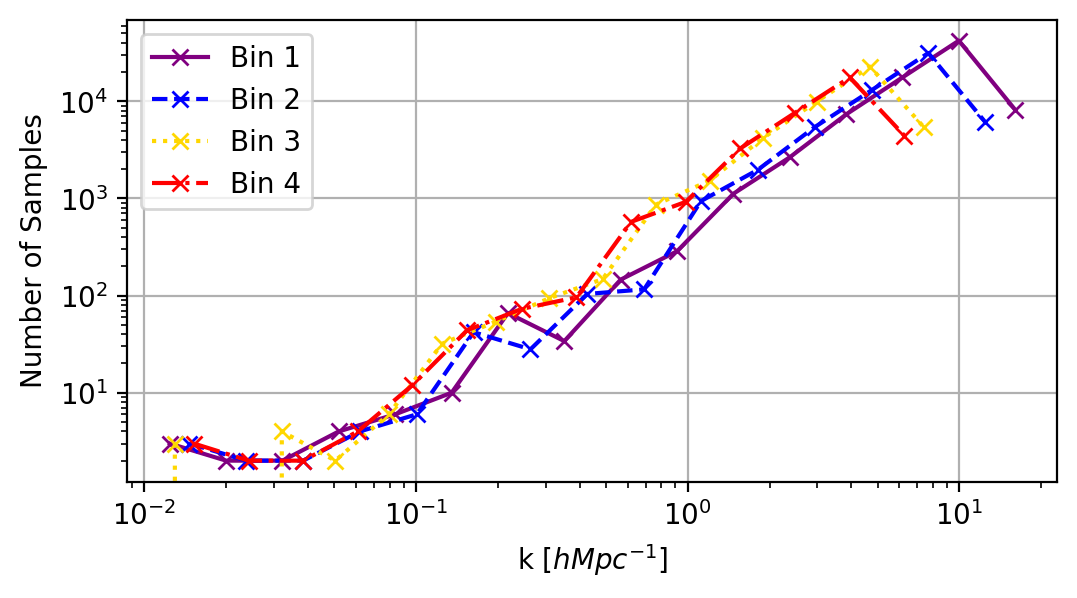

In [25]:
plt.figure(dpi = 200, figsize = (6,3))
for i,((ks,_),nums, col) in enumerate(zip(Pms,num_modes, colors)):
    plt.loglog(ks,nums, color = col, linestyle = linestyles[i], marker = 'x', label = 'Bin ' + str(i+1))

plt.xlabel(r"k [$h Mpc^{-1}]$", size=10)
plt.ylabel('Number of Samples')

plt.grid()
plt.legend()

In [26]:
x_noise = [np.sqrt(lsb.cell_noise(TIM.time).value / (2 * n_gal * nm * w))
        for lsb, n_gal, nm, w, PxG in zip(LSbins, GAL.n_gals, num_modes, window_avgs, PxGs)]
SNR_PxG = [PxG / xn for PxG, xn in zip(PxGs, x_noise)]

In [27]:
#CAMB outputs lists of different ks for each bin so we can't sum them 'apples to apples.'
#So, we'll interpolate Cross powers, SNRs and noise values at matching ks across all bins.
PxG_Interp = [interp1d(ks, PxG) for (ks, _), PxG in zip(Pms, PxGs)]
SNR_PxG_Interp = [interp1d(ks, SNR) for (ks, _), SNR in zip(Pms, SNR_PxG)]
x_noise_Interp = [interp1d(ks, xn) for (ks, _), xn in zip(Pms, x_noise)]

k4 = Pms[3][0] #isolate the list of k modes in bin 4. We'll use that as our default k list. 
aligned_PxGs = [interp(k4) for interp in PxG_Interp] #Interpolate the forecast signals in all bins at the modes in k4.
aligned_SNRs = np.nan_to_num([interp(k4) for interp in SNR_PxG_Interp]) #same for SNRs - nanToNum sets NaNs = 0.
aligned_x_noises = [interp(k4) for interp in x_noise_Interp]#and x_noises.

In [28]:
#sum the SNRs in each bin in quadrature so that we can report a "Total SNR per redshift bin"
quad_SNRs = [np.sqrt(np.sum(SNRs[~np.isnan(SNRs)]**2)) for SNRs in SNR_PxG]

#now sum each k as it is measured in each bin so we can report the total SNR per k bin.
SNR_by_k = np.zeros(len(aligned_SNRs[0]))
for SNRks in aligned_SNRs: SNR_by_k += SNRks
totQuadSNR = np.sqrt(np.sum(SNR_by_k**2))

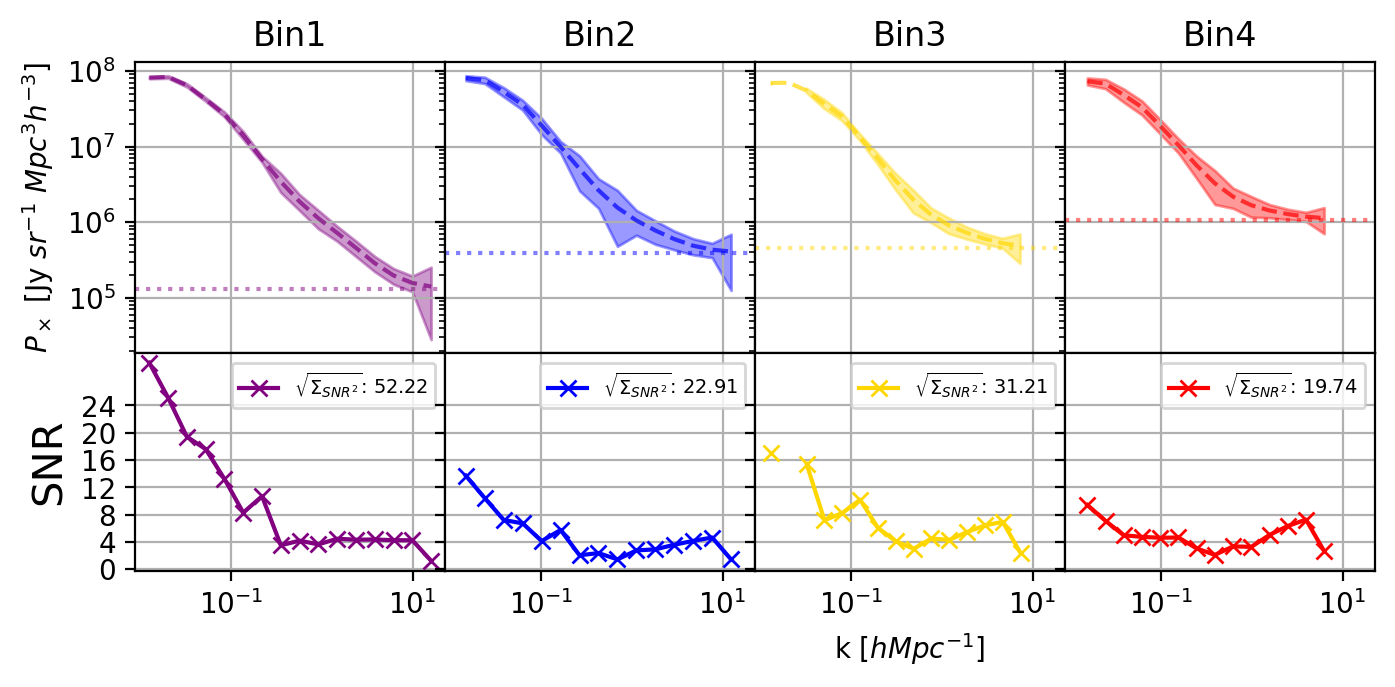

In [29]:
fig, (power, SNR) = plt.subplots(2, 4, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(8, 3.3), dpi = 200)

#plot Cross power as a function of k for each z bin, as well as SNR(k).
for i, PxG in enumerate(PxGs):
    power[i].loglog(Pms[i][0], PxG, color = colors[i], linestyle = '--', alpha = .7)
    power[i].axhline(x_shots[i], color = colors[i], linestyle = ':', alpha = .5)
    power[i].fill_between(Pms[i][0], PxG + x_noise[i],
                   PxG - x_noise[i], color = colors[i], alpha = .4)
    power[i].set_title('Bin'+str(i+1))

    SNR[i].plot(Pms[i][0], SNR_PxG[i], color = colors[i], marker = 'x', 
                label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(quad_SNRs[i],2)))
    power[i].grid()
    SNR[i].grid()
    SNR[i].legend(fontsize = 7)
    SNR[i].set_yticks(np.arange(0, 26, 4.0))


power[0].set_ylabel(r"$P_\times$ [Jy $sr^{-1}$ $Mpc^3 h^{-3}]$", size = 10)

SNR[0].set_ylabel(r"SNR", size = 15)
#power[0].set_xlim(1.2e-1, 0.1e2)

#power[0].set_ylim(1e5, 1e7)
#SNR[0].set_ylim(0,25)
SNR[2].set_xlabel(r"k [$h Mpc^{-1}]$", size=10)
fig.subplots_adjust(hspace=0, wspace=0)

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})
plt.rcParams.update({'lines.dashed_pattern':[5,3]})

plt.show()
plt.close()

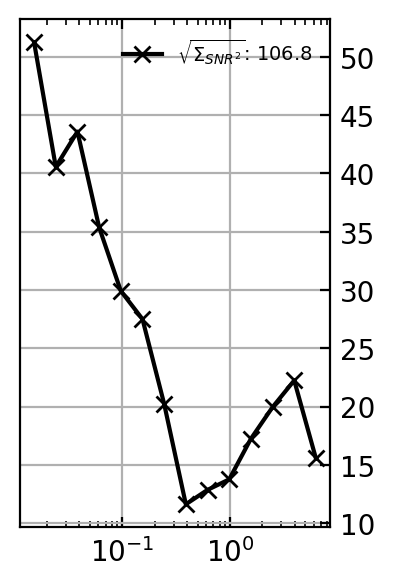

In [30]:
fig, total = plt.subplots(1,1, dpi = 200, figsize = (2,3.3))
total.semilogx(k4, SNR_by_k, color = 'black', marker = 'x', 
        label = r'$\sqrt{\Sigma_{SNR^2}}$: ' + str(np.around(totQuadSNR,2)))
total.grid()
total.legend(fontsize = 7)
total.yaxis.tick_right()

In [31]:
# Changing from proposal SFRD->CII to DeLooze's prescription changes SNR by a small factor 2-4% 
# (depending on z-bin). this percentage/fractional change is exactly same across all k-bins, 

In [32]:
# Changing to Spinoglio's prescription changes SNR by large factors: ~70%
# again, constant across all k-bins, for a given z-bin